In [1]:
import sys
sys.path.insert(0, "./lib/")

import VOC2012DataProvider
import VOC2012_npz_files_writter
import tensorflow as tf
import os.path
import numpy as np
from PIL import Image
from Agent import ObjLocaliser
import time

/home/mohammad/Tensorflow/local/lib/python2.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.23) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)
/home/mohammad/Tensorflow/local/lib/python2.7/site-packages/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 2, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)


In [2]:
#This cell reads VOC 2012 dataset and save them in .npz files for future.
#The process of reading data and put them in prper format is time consuming so they are stored in a file.

xml_path = "../VOC2012/Annotations/*.xml"
destination = "../data/"

#It splits dataset to 80% for training and 20% validation.
if not (os.path.isfile(destination+"test_input.npz") or os.path.isfile(destination+"test_target.npz")):
    VOC2012_npz_files_writter.writting_files(xml_path, destination, percentage=0)
    print("Files are ready!!!")
else:
    print("Records have already prepared!!!")

Records have already prepared!!!


In [3]:
inputs = VOC2012DataProvider.PascalDataProvider('train', batch_size=50)

In [4]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name = "W")

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name = "B")

def conv2d(x, W, stride):
    return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='SAME')

def max_pool(x, kernel_size, stride, name = "pool"):
    return tf.nn.max_pool(x, ksize=[1, kernel_size, kernel_size, 1],
    strides=[1, stride, stride, 1], padding='SAME', name = name)

In [5]:
x = tf.placeholder(tf.float32, shape=[None, 224*224*3], name = 'x')

x_image = tf.reshape(x, [-1, 224, 224, 3])
tf.summary.image('input', x_image, 1)


#First Conv layer weights and biases
W_conv1 = weight_variable([7, 7, 3, 96]) #[filter_size, filter_size, num_input_channels, num_filters]
b_conv1 = bias_variable([96])
#Second conv layer weights and biases
W_conv2 = weight_variable([5, 5, 96, 256])
b_conv2 = bias_variable([256])
#Third conv layer weights and biases
W_conv3 = weight_variable([3, 3, 256, 384])
b_conv3 = bias_variable([384])
#Fourth conv layer weights and biases
W_conv4 = weight_variable([3, 3, 384, 384])
b_conv4 = bias_variable([384])
#First fully-connected layer weights and biases
W_fc1 = weight_variable([7*7*384, 4096])
b_fc1 = bias_variable([4096])
#Second fully-connected layer weights and biases
W_fc2 = weight_variable([4096, 4096])
b_fc2 = bias_variable([4096])
#Output layer weights and biases
W_fc3 = weight_variable([4096, 10])
b_fc3 = bias_variable([10])



with tf.name_scope("conv1"):
    #First conv layer
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1, 2) + b_conv1, name = "hconv1") #output shape = (112,112,96)
    #First conv layer pooling layer
    h_pool1 = max_pool(h_conv1, 3, 2, name = "pool1") #output shape = (56,56,96)

with tf.name_scope("conv2"):    
    #Second conv layer
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2, 2) + b_conv2, name = "hconv2") #output shape = (28, 28, 256)
    #Second conv layer pooling layer
    h_pool2 = max_pool(h_conv2, 3, 2, name = "pool2") #output shape = (14, 14, 256)

with tf.name_scope("conv3"):
    #Third conv layer
    h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3, 1) + b_conv3, name = "hconv3") #output shape = (14, 14, 384)

with tf.name_scope("conv4"):    
    #Fourth conv layer
    h_conv4 = tf.nn.relu(conv2d(h_conv3, W_conv4, 1) + b_conv4, name = "hconv4") #output shape = (14, 14, 384)
    #Fourth conv layer pooling layer
    h_pool2 = max_pool(h_conv4, 3, 2, name = "pool4") #output shape = (7, 7, 384)

with tf.name_scope("fc1"):    
    #First fully-connected layer
    h_flat1 = tf.reshape(h_pool2, [-1, 7*7*384])
    h_fc1 = tf.nn.relu(tf.matmul(h_flat1, W_fc1) + b_fc1, name = "hfc1") #(input, output) = (7*7*384, 4096)

with tf.name_scope("fc2"):    
    #Second fully-connected layer
    h_fc2 = tf.nn.relu(tf.matmul(h_fc1, W_fc2) + b_fc2, name = "hfc2") #(input, output) = (4096, 4096)

with tf.name_scope("output"):
    #Output layer
    h_fc3 = tf.nn.relu(tf.matmul(h_fc2, W_fc3) + b_fc3, name = "hfc3") #(input, output) = (4096, 10)
    Qout = tf.nn.softmax(h_fc3)

In [6]:
predict = tf.argmax(Qout,1)

with tf.name_scope("loss"):
    #Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
    nextQ = tf.placeholder(shape=[1,10],dtype=tf.float32, name = 'nextQ')
    loss = tf.reduce_sum(tf.square(nextQ - Qout))
    tf.summary.scalar("loss", loss)
        
with tf.name_scope("train"):
    trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
    updateModel = trainer.minimize(loss)
    
summ = tf.summary.merge_all()

sess = tf.Session()
sess.run(tf.global_variables_initializer())

writer = tf.summary.FileWriter("./report/1")
writer.add_graph(sess.graph)

0.0


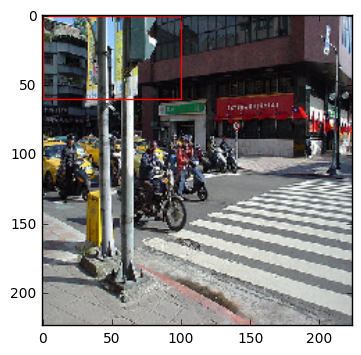

0.0


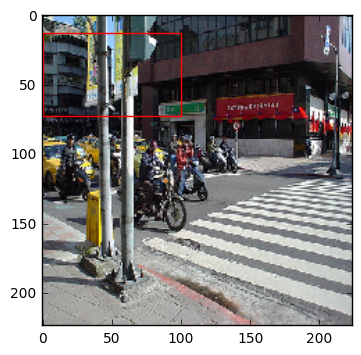

0.0


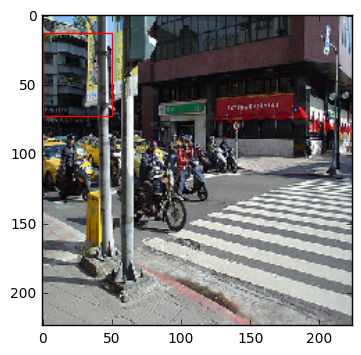

0.0


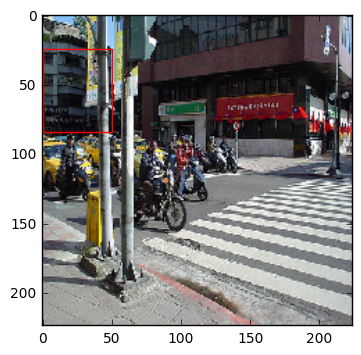

0.0


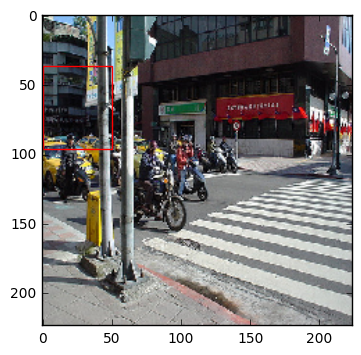

0.0


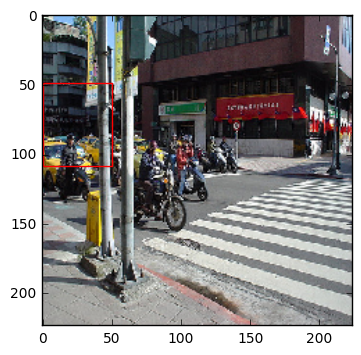

0.0


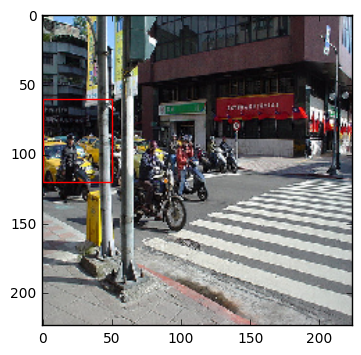

0.0


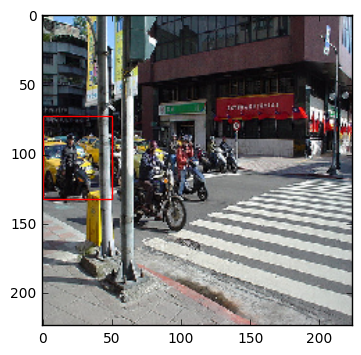

0.0


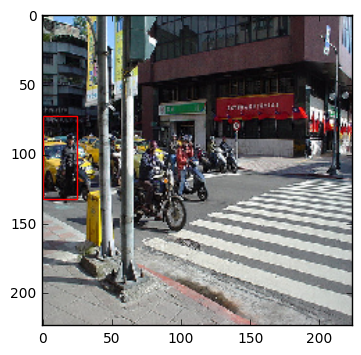

0.0


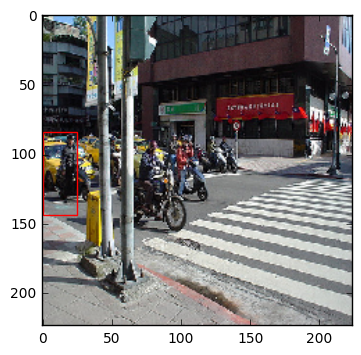

0.0


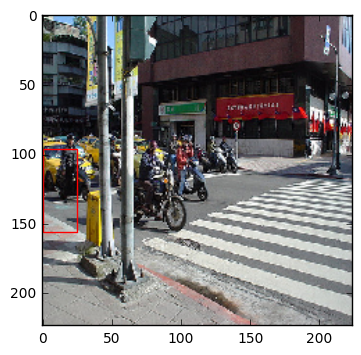

KeyboardInterrupt: 

In [7]:
e = 0.1
y = .99
jList = []
rList = []

for input_batch, target_batch in inputs:
    for i in range(len(input_batch)):
        rAll = 0
        #first_obj = [target_batch[i]['xmax'][0], target_batch[i]['xmin'][0], target_batch[i]['ymax'][0], target_batch[i]['ymin'][0]]
        PILimage = Image.frombytes("RGB",(inputs.inputs[i]['image_width'],inputs.inputs[i]['image_height']),inputs.inputs[i]['image'])
        #ObjLocaliser object should be initialised with a PIL image object and a dictionary of bounding boxes
        dqn_agent = ObjLocaliser(PILimage, target_batch[i])

        for j in range(50):
            
            s = np.array(dqn_agent.wrapping(), dtype = 'float').reshape((1,224*224*3))
            
            a,allQ = sess.run([predict,Qout],feed_dict={x: s})
            
            if np.random.rand(1) < e:
                a[0] = np.random.randint(10, size=1)
                
            #Get new state and reward from environment
            r = dqn_agent.takingActions(a[0])
            time.sleep(2)
            print r
            dqn_agent.drawActions()
            s1 = np.array(dqn_agent.wrapping(), dtype = 'float').reshape((1,224*224*3))
            
            #Obtain the Q' values by feeding the new state through our network
            Q1 = sess.run(Qout,feed_dict={x:s1})
            
            #Obtain maxQ' and set our target value for chosen action.
            maxQ1 = np.max(Q1)
            targetQ = allQ
            targetQ[0,a[0]] = r + y*maxQ1
            
            #Train our network using target and predicted Q values
            _ = sess.run(updateModel,feed_dict={x:s, nextQ:targetQ})
            #writer.add_summary(repo, j)
            
            rAll += r
            jList.append(j)
            rList.append(rAll)
            
            
            #_, batch_error, batch_acc = sess.run(
            #    [optimizer, cost, accuracy], 
            #    feed_dict={x: input_batch[i]['image']})
        print rAll
        

In [8]:
dqn_agent.targets

[[62.0, 231.0, 27.0, 144.0],
 [206.0, 253.0, 154.0, 154.0],
 [247.0, 222.0, 212.0, 147.0]]

In [ ]:
a=sess.graph.get_operation_by_name('fc3')
a.outputs

how to add dropout layer: https://stackoverflow.com/questions/40955223/tensorflow-python-framework-errors-invalidargumenterror-input-to-reshape-is-a-t